<a href="https://colab.research.google.com/github/tuomaseerola/onsetsync/blob/master/onsetsync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# onsetsync

A Jupyter notebook with code examples in R for _onsetsync_ package by [Tuomas Eerola](https://www.durham.ac.uk/staff/tuomas-eerola/), [Music and Science Lab]() at [Durham University](https://www.durham.ac.uk).

To run the code in your browser, open the file in Colab (click the icon "Open in Colab"). Alternatively, you can download the notebook and run it locally.

File `onsetsync.ipynb` | Version `7/11/2022` |

---

## Load libraries
This might take a minute or two as it needs to be install packages that are not initially in the Colab virtual space.

In [1]:
library(ggplot2,quietly = TRUE)
library(tidyverse,quietly = TRUE)
devtools::install_github("tuomaseerola/onsetsync")
library(onsetsync)
library(reshape2)
library(httr)   # for reading data from online sources
ver <- packageVersion('onsetsync')
print(ver)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.5      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



vctrs   (0.4.2 -> 0.5.0) [CRAN]
tuneR   (1.4.0 -> 1.4.1) [CRAN]
cpp11   (0.4.2 -> 0.4.3) [CRAN]
ggplot2 (3.3.6 -> 3.4.0) [CRAN]


Installing 4 packages: vctrs, tuneR, cpp11, ggplot2




  There is a binary version available but the source version is later:
        binary source needs_compilation
ggplot2  3.3.6  3.4.0             FALSE


The downloaded binary packages are in
	/var/folders/b0/vtr2rd_96119zlr64t5hvlgr0000gp/T//RtmpKpPzya/downloaded_packages


installing the source package ‘ggplot2’




* checking for file ‘/private/var/folders/b0/vtr2rd_96119zlr64t5hvlgr0000gp/T/RtmpKpPzya/remotes1bf96856de9f/tuomaseerola-onsetsync-4f061ff/DESCRIPTION’ ... OK
* preparing ‘onsetsync’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
  an installed package
* building ‘onsetsync_0.4.4.tar.gz’




Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




[1] ‘0.4.4’


## Input -- Read Data
This is the first figure. 

In [2]:
CSS_Song2_Onset <- get_OSF_csv('8a347') # Get onsets
print(head(CSS_Song2_Onset[,1:8,]))

   Piece Label.SD SD Clave_. Section Clave     Bass   Guitar
1 Song_2      1:1  1       1     Son    NA       NA       NA
2 Song_2      1:2  2       N     Son    NA       NA 5.281932
3 Song_2      1:3  3       N     Son    NA       NA 5.480643
4 Song_2      1:4  4       2     Son    NA 5.714555 5.707537
5 Song_2      1:5  5       N     Son    NA 5.927078 5.939071
6 Song_2      1:6  6       N     Son    NA       NA 6.153243


In [3]:
CSS_Song2_Metre <- get_OSF_csv('4cdpr') # Annotations for cycles

CSS_Song2_Onset <- dplyr::select(CSS_Song2_Onset,
                                 Label.SD,SD,Clave,Bass,Guitar,Tres)

CSS_Song2 <- add_annotation(df = CSS_Song2_Onset,
                            annotation = CSS_Song2_Metre$Cycle,
                            time = CSS_Song2_Metre$Time,
                            reference = 'Label.SD')
# Add isochronous beats to the data frame
CSS_Song2 <- add_isobeats(df = CSS_Song2,
                          instr = 'CycleTime',
                          beat = 'SD')

colnames(CSS_Song2)[9] <- 'Ann.Iso' # Rename
# Add isochronous beats based on mean timing of guitar, tres, and clave

CSS_Song2 <- add_isobeats(df = CSS_Song2,
                          instr = c('Guitar','Tres','Clave'),
                          beat = 'SD')

## Summaries

In [4]:
tab1 <- summarise_onsets(df = CSS_Song2,
                         instr = c('Clave','Bass','Guitar','Tres'))
print(knitr::kable(tab1,format = "markdown", digits = 1,
                   caption = 'Descriptives for the onset time differences (ms).'))



Table: Descriptives for the onset time differences (ms).

|       |    N|    Md|     M|    SD|   Min|    Max|
|:------|----:|-----:|-----:|-----:|-----:|------:|
|Clave  |  481| 666.8| 703.5| 174.0| 192.0| 1558.1|
|Bass   |  480| 467.6| 709.6| 433.0| 180.0| 1985.2|
|Guitar | 1385| 223.6| 244.8|  91.9| 175.1| 1694.9|
|Tres   |  894| 245.0| 372.4| 235.7| 147.1| 1986.5|


## Visualise onset structures

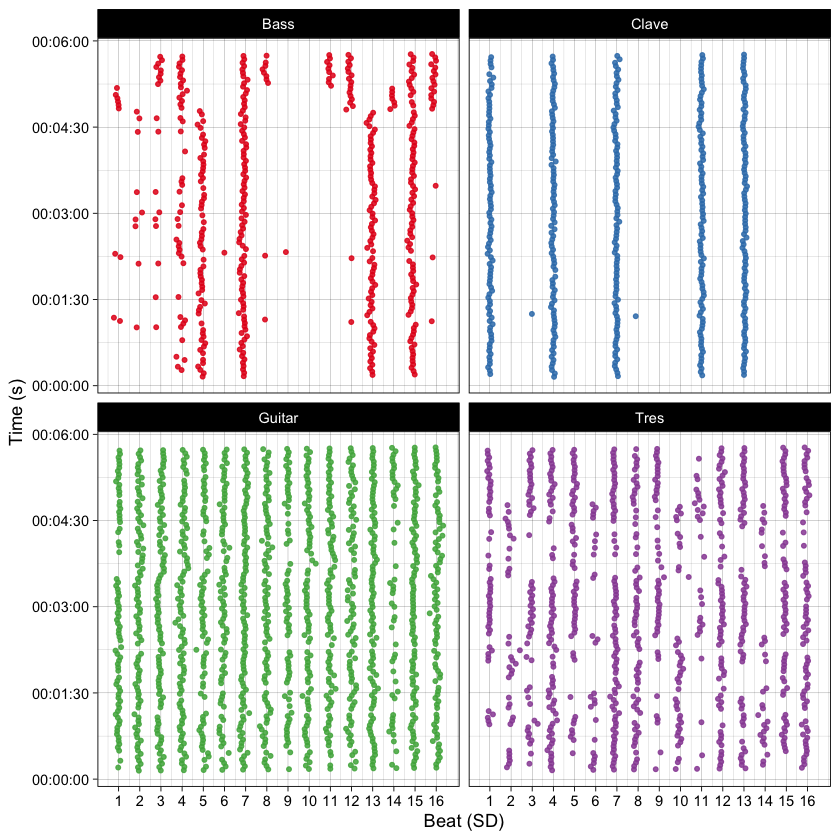

In [5]:
fig1 <- plot_by_beat(df = CSS_Song2,
                     instr = c('Bass','Clave','Guitar','Tres'),
                     beat = 'SD',
                     virtual = 'Isochronous.SD.Time',
                     pcols = 2)
print(fig1)

## Deviation from isochrony

In [ ]:
fig2 <- plot_by_beat(df = CSS_Song2,
                     instr = c('Bass','Tres'),
                     beat = 'SD',
                     virtual = 'Isochronous.SD.Time',
                     pcols=1,
                     griddeviations = TRUE)
print(fig2)

## Synchrony between the instruments

In [7]:
set.seed(1201) # set random seed
N <- 100 # Let's select 100 onsets
d1 <- sync_sample_paired(CSS_Song2,'Clave','Bass',N,1,'SD',TRUE)
print(paste('Mean asynchrony of',round(mean(d1$asynch*1000),1),
            'ms & standard deviation of',round(sd(d1$asynch*1000),1),'ms'))

[1] "onsets in common: 238"
[1] "Mean asynchrony of 17.9 ms & standard deviation of 18.2 ms"


## Synchrony between the instruments

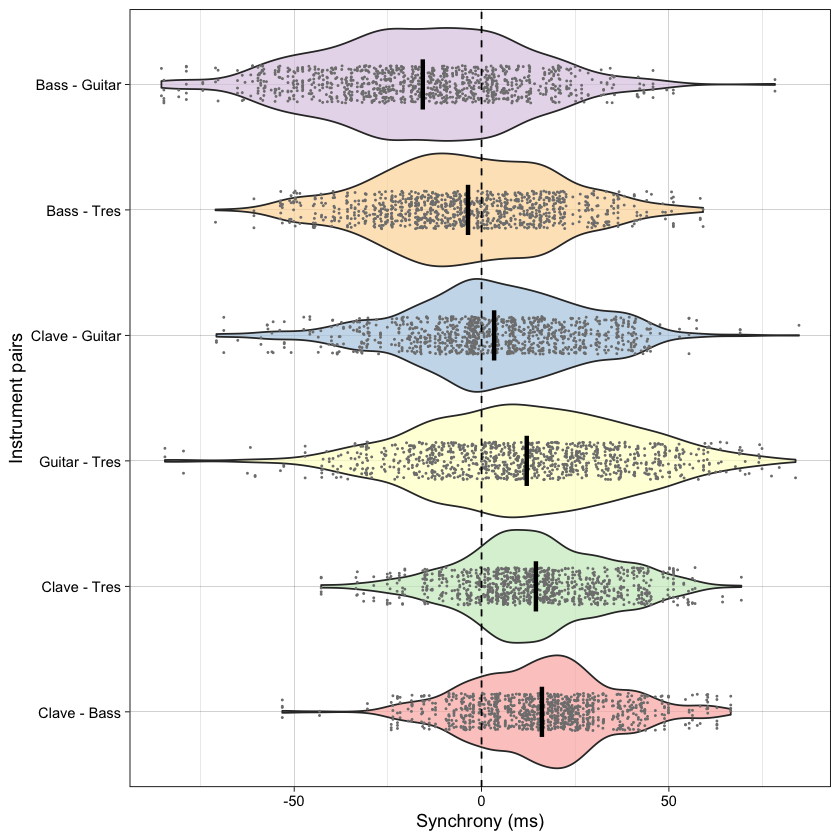

In [8]:
inst <- c('Clave','Bass','Guitar','Tres') # Define instruments
dn <- sync_execute_pairs(CSS_Song2,inst,N,10,'SD')
print(plot_by_pair(dn))  # plot